In [5]:
!pip install  transformers

In [ ]:
import json
import os
import glob

import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path

import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelWithLMHead
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Config

from IPython import display

In [7]:
file_path = '/content/ferdousi.txt'  # Replace 'your_file.txt' with the path to your text file
import pandas as pd

with open(file_path, 'r', encoding='utf-8') as file:
  lines = file.readlines()

  # Create a list of dictionaries where each dictionary represents a row in the DataFrame
  data = [{'bate 2': lines[i + 1].strip() if i + 1 < len(lines) else None, 'bate 1': lines[i].strip()}
          for i in range(0, len(lines), 2)]

  # creating a DataFrame from the list of dictionaries
  poem_df = pd.DataFrame(data)
poem_df.drop(0, inplace=True)  # droping the first row and modify the DataFrame in-place
poem_df.reset_index(drop=True, inplace=True)  # reseting the index in-place
poem_df.head()


,bate 2,bate 1
0,کزین برتر اندیشه برنگذرد,به نام خداوند جان و خرد
1,خداوند روزی ده رهنمای,خداوند نام و خداوند جای
2,فروزنده ماه و ناهید و مهر,خداوند کیوان و گردان سپهر
3,نگارندهٔ بر شده پیکرست,ز نام و نشان و گمان برترست
4,نبینی مرنجان دو بیننده را,به بینندگان آفریننده را


In [10]:

poem_df = poem_df.dropna()
poem_df = poem_df.reset_index(drop=True)
poem_df["text"] = poem_df["bate 1"] + "<|startoftext|>" + poem_df["bate 2"].apply(lambda t: t.replace("    ", "<sep>").replace("\t", "<sep>"))

poem_df.head()

,bate 2,bate 1,text
0,کزین برتر اندیشه برنگذرد,به نام خداوند جان و خرد,به نام خداوند جان و خرد<|startoftext|>کزین برت...
1,خداوند روزی ده رهنمای,خداوند نام و خداوند جای,خداوند نام و خداوند جای<|startoftext|>خداوند ر...
2,فروزنده ماه و ناهید و مهر,خداوند کیوان و گردان سپهر,خداوند کیوان و گردان سپهر<|startoftext|>فروزند...
3,نگارندهٔ بر شده پیکرست,ز نام و نشان و گمان برترست,ز نام و نشان و گمان برترست<|startoftext|>نگارن...
4,نبینی مرنجان دو بیننده را,به بینندگان آفریننده را,به بینندگان آفریننده را<|startoftext|>نبینی مر...


In [20]:
model_name = "HooshvareLab/gpt2-fa"

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>',
    unk_token='<unk>'
)
tokenizer.add_special_tokens({
    "bos_token": '</s>',
    "eos_token": '</s>',
    "pad_token": '<pad>',
    "unk_token": '<unk>'
})

config = AutoConfig.from_pretrained(
    model_name,
    bos_token_id=tokenizer("<s>")["input_ids"][0],
    eos_token_id=tokenizer("</s>")["input_ids"][0],
    pad_token_id=tokenizer("<pad>")["input_ids"][0],
    unk_token_id=tokenizer("<unk>")["input_ids"][0],
)

tokenizer.save_pretrained("/content/gpt2/")
config.save_pretrained("/content/gpt2/")

!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin" -P /content/gpt2/
!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/tokenizer.json" -P /content/gpt2/

--2024-01-22 00:28:29--  https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 18.164.174.23, 18.164.174.118, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.23|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/HooshvareLab/gpt2-fa/46b0b806c740a0f0a9f056f5574c5fa896166fe844945fd3c849bf34365e5060?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1706142509&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNjE0MjUwOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9Ib29zaHZhcmVMYWIvZ3B0Mi1mYS80NmIwYjgwNmM3NDBhMGYwYTlmMDU2ZjU1NzRjNWZhODk2MTY2ZmU4NDQ5NDVmZDNjODQ5YmYzNDM2NWU1MDYwP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&

In [15]:
from torch.utils.data import Dataset  # this is the pytorch class import
import torch
torch.manual_seed(42)
from tqdm import tqdm

class FerdousiDataset(Dataset):

    def __init__(self, txt_list, tokenizer, max_length=1024):

        self.tokenizer = tokenizer  # the gpt2 tokenizer we instantiated
        self.input_ids = []
        self.attn_masks = []

        for txt in tqdm(txt_list):
            """
            This loop will iterate through each entry in the flavour text corpus.
            For each bit of text it will prepend it with the start of text token,
            then append the end of text token and pad to the maximum length with the
            pad token.
            """

            encodings_dict = tokenizer('<s>' + txt + '</s>',
                                       truncation=True,
                                       max_length=max_length,
                                       padding="max_length")

            """
            Each iteration then appends either the encoded tensor to a list,
            or the attention mask for that encoding to a list. The attention mask is
            a binary list of 1's or 0's which determine whether the langauge model
            should take that token into consideration or not.
            """
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [16]:
max_seq = 40
texts = poem_df["text"].values.tolist()
poem_ds = FerdousiDataset(texts, tokenizer, max_length=max_seq)
print("\n",texts[0])
print(poem_ds[0][0])
print(poem_ds[0][1])

100%|██████████| 49608/49608 [00:11<00:00, 4416.13it/s]


 به نام خداوند جان و خرد<|startoftext|>کزین برتر اندیشه برنگذرد
tensor([    0,   490,   561,  6733,  1305,   293,  2964,     6,  2639,   297,
         3206,  6188, 29631,   383,   343,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [17]:
from torch.utils.data import random_split

dataset = FerdousiDataset(texts, tokenizer, max_length=max_seq)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {len(train_dataset)} samples for training, and {len(val_dataset)} samples for validation testing'

100%|██████████| 49608/49608 [00:09<00:00, 5037.17it/s]


'There are 44647 samples for training, and 4961 samples for validation testing'

In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8
)

model and optimizer config

In [24]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np
from transformers import get_linear_schedule_with_warmup

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('./gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("./gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


from transformers import AdamW

epochs = 3
warmup_steps = 1e2
sample_every = 300

# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters.
optimizer = AdamW(
    model.parameters(),
    lr=5e-4,
    eps=1e-8
)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Before fine-tuning

In [25]:
sample_bate = poem_df.iloc[np.random.randint(0, len(poem_df)),1]
sample_input = f"<s>{sample_bate}<|startoftext|>"
print(sample_input)
sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
sample_input_ids = sample_input_ids.to(device)

sample_outputs = model.generate(
    input_ids=sample_input_ids,
    # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
    do_sample=True,
    top_k=50,
    max_length=50,
    top_p=0.95,
    num_return_sequences=1
)
for i, sample_output in enumerate(sample_outputs):
    gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
    gen_sample_output = gen_sample_output.replace("<|startoftext|>", "\n")
    gen_sample_output = gen_sample_output.replace("<s>", "")
    gen_sample_output = gen_sample_output.replace("</s>", "")
    gen_sample_output = gen_sample_output.replace("<sep>", "\n")

    print(f'Example output: {gen_sample_output}')

<s>جوان گرچه دانا بود با گهر<|startoftext|>
Example output: جوان گرچه دانا بود با گهر
ک و عوامفریبی که در کنار اشرافزادگان خود می‌دید که من که می‌توانستم از آن به عنوان یک شهروند مستقل و مستقل در جامعه‌ی خودم استفاده کنم و آن را به نحوی به


# training and fine-tuning

In [27]:
import random
from tqdm import tqdm



training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs), position=0):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:
            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.')

            model.eval()
            rnd_idx = np.random.randint(0, len(poem_df))
            sample_bate = poem_df.iloc[rnd_idx,1]
            sample_input = f"<s>{sample_bate}<|startoftext|>"
            sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
            sample_input_ids = sample_input_ids.to(device)

            sample_outputs = model.generate(
                input_ids=sample_input_ids,
                # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
                do_sample=True,
                top_k=50,
                max_length=50,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
                gen_sample_output = gen_sample_output.replace("<|startoftext|>", "\n")
                gen_sample_output = gen_sample_output.replace("<s>", "")
                gen_sample_output = gen_sample_output.replace("</s>", "")
                gen_sample_output = gen_sample_output.replace("<sep>", "\n")
                ground_truth_bate = poem_df.iloc[rnd_idx,0]+"\t\t"+poem_df.iloc[rnd_idx,1]
                print(f'example input: {poem_df.iloc[rnd_idx,1]}')
                print(f'Example ground_truth_bate: {ground_truth_bate}')
                print(f'Example output: {gen_sample_output}')

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)


    print()
    print(f'Average Training Loss: {avg_train_loss}. Epoch ')
    print()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)
            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print()
    print(f'Validation loss: {avg_val_loss}. Validation ')
    print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Beginning epoch 1 of 3

Batch 300 of 5581. Loss:1.7927844524383545.
example input: نوندی ز گفتار کارآگهان
Example ground_truth_bate: بیامد به نزدیک شاه جهان		نوندی ز گفتار کارآگهان
Example output: نوندی ز گفتار کارآگهان
سپه را چنین گفت کای شهریار

Batch 600 of 5581. Loss:1.5377370119094849.
example input: سرانجام اگر راه جویی بداد
Example ground_truth_bate: هیونی برافگن بکردار باد		سرانجام اگر راه جویی بداد
Example output: سرانجام اگر راه جویی بداد
یکی سوی تور دارد به دماد

Batch 900 of 5581. Loss:1.7978343963623047.
example input: بسی آفرین کرد بر شهریار
Example ground_truth_bate: بدان شادمان گردش روزگار		بسی آفرین کرد بر شهریار
Example output: بسی آفرین کرد بر شهریار
همان دادگر شهریار

Batch 1200 of 5581. Loss:1.5376955270767212.
example input: برانگیزم از گاه کاووس را
Example ground_truth_bate: از ایران ببرم پی طوس را		برانگیزم از گاه کاووس را
Example output: برانگیزم از گاه کاووس را
که ای پیر شایستهٔ کار

Batch 1500 of 5581. Loss:1.5931882858276367.
example input: سواران ز بس رنج و

 33%|███▎      | 1/3 [11:43<23:27, 703.61s/it]


Validation loss: 1.441193657412813. Validation 

Beginning epoch 2 of 3

Batch 300 of 5581. Loss:1.2839030027389526.
example input: ازان درد بگریست افراسیاب
Example ground_truth_bate: همی کند موی و همی ریخت آب		ازان درد بگریست افراسیاب
Example output: ازان درد بگریست افراسیاب
همی پوست رستم بدو خواب

Batch 600 of 5581. Loss:1.4816105365753174.
example input: بفرمود تا زو بپرسند شاه
Example ground_truth_bate: که جام نبید از چه داری نگاه		بفرمود تا زو بپرسند شاه
Example output: بفرمود تا زو بپرسند شاه
بیامد بدرگاه سالار شاه

Batch 900 of 5581. Loss:1.1442819833755493.
example input: ترا بهتر آید که فرمان کنی
Example ground_truth_bate: رخ نامور سوی توران کنی		ترا بهتر آید که فرمان کنی
Example output: ترا بهتر آید که فرمان کنی
چو خسرو که فرمان دهد

Batch 1200 of 5581. Loss:1.228763461112976.
example input: ز تو دور شد فره و بخردی
Example ground_truth_bate: بیابی تو بادافره ایزدی		ز تو دور شد فره و بخردی
Example output: ز تو دور شد فره و بخردی
سرتاج بر دست تو افسر بدی

Batch 1500 of 5581. L

 67%|██████▋   | 2/3 [23:40<11:51, 711.46s/it]


Validation loss: 1.3329771745608048. Validation 

Beginning epoch 3 of 3

Batch 300 of 5581. Loss:1.0132931470870972.
example input: همان نیز یاد گنهکار مرد
Example ground_truth_bate: نباشی به بازار ننگ و نبرد		همان نیز یاد گنهکار مرد
Example output: همان نیز یاد گنهکار مرد
که باشد خردمند را روزگار نبرد

Batch 600 of 5581. Loss:0.8958872556686401.
example input: بران استخوان بر نگاریده پاک
Example ground_truth_bate: نبینی به شهر اندرون گرد و خاک		بران استخوان بر نگاریده پاک
Example output: بران استخوان بر نگاریده پاک
چو خواهی که بادی دل و دست و مغاک

Batch 900 of 5581. Loss:0.9557551741600037.
example input: از ایدر بران سان شوم سوی جنگ
Example ground_truth_bate: بدانگه کجا پای دارد نهنگ		از ایدر بران سان شوم سوی جنگ
Example output: از ایدر بران سان شوم سوی جنگ
به جنگ اندر آریم با او پلنگ

Batch 1200 of 5581. Loss:1.0633039474487305.
example input: چنین راند برسر سپهر بلند
Example ground_truth_bate: که آید زمن درد ورنج و گزند		چنین راند برسر سپهر بلند
Example output: چنین راند برسر سپ

100%|██████████| 3/3 [34:55<00:00, 698.61s/it]


Validation loss: 1.3535508790837778. Validation 



saving the fine-tuned model

In [28]:
output_dir = '/content/gpt2-fa-poetry'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/gpt2-fa-poetry/tokenizer_config.json',
 '/content/gpt2-fa-poetry/special_tokens_map.json',
 '/content/gpt2-fa-poetry/vocab.json',
 '/content/gpt2-fa-poetry/merges.txt',
 '/content/gpt2-fa-poetry/added_tokens.json',
 '/content/gpt2-fa-poetry/tokenizer.json')

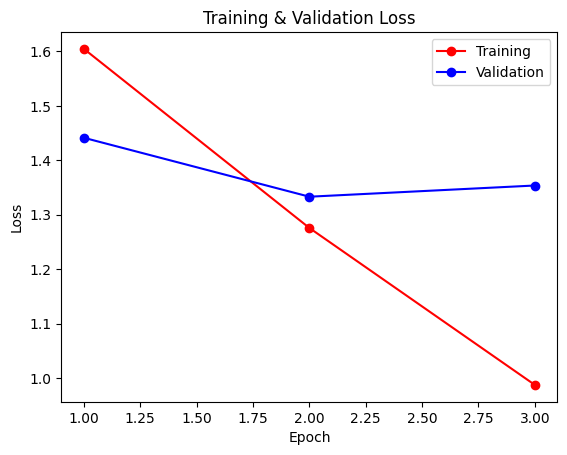

In [66]:

import matplotlib.pyplot as plt

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Increase the plot size and font size.

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'r-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'b-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# generating poem with BLEU score

In [67]:
from nltk.translate.bleu_score import sentence_bleu
import re


def besorai( max_length=128, num_return_sequences=3):
    model.eval()
    sample_misra_idx = np.random.randint(0, len(poem_df))
    sample_misra = poem_df.iloc[sample_misra_idx,1]
    sample_bate = poem_df.iloc[sample_misra_idx,2]
    sample_bate =  re.sub("\n+", "\n", sample_bate.replace("<sep>", "\n"))
    sample_bate =  "<p>" + sample_bate.replace("\n", "<br/>").replace("<|startoftext|>", "<br/>").strip() + "</p>"
    prompt = f"<s>{sample_misra}<|startoftext|>"
    # print(prompt)

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    decoded_outputs = model.generate(
        generated,
        do_sample=True,
        top_k=50,
        max_length=max_length,
        top_p=0.95,
        num_return_sequences=1
    )


    outputs = ""
    for i, output in enumerate(decoded_outputs):
        o = tokenizer.decode(output, skip_special_tokens=False)
        o = o.replace("<s>", "").replace("</s>", "")
        outputs += o
    outputs =  re.sub("\n+", "\n", outputs.replace("<sep>", "\n"))
    outputs =  "<p>" + outputs.replace("\n", "<br/>").replace("<|startoftext|>", "<br/>").strip() + "</p>"
    print(f'example input: {poem_df.iloc[sample_misra_idx,1]}')
    print(f'Example ground_truth_bate: {sample_bate}')
    print("-"*15)
    print(f'Example output: {outputs}')
    print("-"*15)
    reference = [
        sample_bate.split()
    ]
    candidate = outputs.split()
    print('BLEU score -> {}'.format(sentence_bleu(reference, candidate )))
    print("#"*25)


In [68]:
for i in range(20):
  besorai()

example input: به بیگانگان هم نشاید بنیز
Example ground_truth_bate: <p>به بیگانگان هم نشاید بنیز<br/>نجوید کسی عاج از چوب شیز</p>
---------------
Example output: <p>به بیگانگان هم نشاید بنیز<br/>تو خواهی بدن آنک او را به چیز</p>
---------------
BLEU score -> 0.21200626759025185
#########################
example input: سر خویش گیرم بمانم بجای
Example ground_truth_bate: <p>سر خویش گیرم بمانم بجای<br/>بزرگی نباشد نه مردی ورای</p>
---------------
Example output: <p>سر خویش گیرم بمانم بجای<br/>نه هرگز شنیدم چنین داستان<br/>بپای</p>
---------------
BLEU score -> 0.2984745896009823
#########################
example input: فراوان به درویش دینار داد
Example ground_truth_bate: <p>فراوان به درویش دینار داد<br/>همان خوردنیهای بسیار داد</p>
---------------
Example output: <p>فراوان به درویش دینار داد<br/>بیاویخت از خویشتن کار داد</p>
---------------
BLEU score -> 0.3155984539112945
#########################
example input: ز هر چیز کز من به خوبی بخواست
Example ground_truth_bate: <p>ز هر چیز کز من به

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


example input: همه راستی کن که از راستی
Example ground_truth_bate: <p>همه راستی کن که از راستی<br/>بپیچد سر از کژی و کاستی</p>
---------------
Example output: <p>همه راستی کن که از راستی<br/>شود بی سر مرد کایدون</p>
---------------
BLEU score -> 0.37200908038405156
#########################
example input: به هنگام شادی درختی مکار
Example ground_truth_bate: <p>به هنگام شادی درختی مکار<br/>که زهر آورد بار او روزگار</p>
---------------
Example output: <p>به هنگام شادی درختی مکار<br/>به گیتی چو از تخم اسفندیار</p>
---------------
BLEU score -> 0.2626909894424158
#########################
example input: قبایش سپید و حمایل سیاه
Example ground_truth_bate: <p>قبایش سپید و حمایل سیاه<br/>همی راند ابلق میان سپاه</p>
---------------
Example output: <p>قبایش سپید و حمایل سیاه<br/>بدان تا نبیند جز از رنج راه</p>
---------------
BLEU score -> 0.23462350320528
#########################
example input: سپه را درم دادن آغاز کرد
Example ground_truth_bate: <p>سپه را درم دادن آغاز کرد<br/>بدشت آمد و رزم را